<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/gmm_time_normalise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time-Adjusted Normalization of Multivariate Measurements**

(Fayyaz Minhas)

Each patient $i$ has a **single measurement** $g_i \in \mathbb{R}^d$ recorded at a specific time $t_i$. Since measurement distributions change over time, we aim to transform all measurements to a common reference time $t^*$.

## **Mathematical Formulation**
Let:
- $g_i$ be the measurement vector for patient $i$, recorded at time $t_i$.
- $\mu_{t_i}$ and $\Sigma_{t_i}$ be the estimated **mean vector** and **covariance matrix** of $g$ at time $t_i$.
- $\mu_{t^*}$ and $\Sigma_{t^*}$ be the mean and covariance at the **reference time** $t^*$.
- $\Sigma_{t_i}^{-\frac{1}{2}}$ be the **whitening transform**, which removes the covariance structure at $t_i$.
- $\Sigma_{t^*}^{\frac{1}{2}}$ be the **re-scaling transform**, which applies the covariance structure of the reference time $t^*$.

The transformation to adjust $g_i$ to the reference time $t^*$ is given by:

$$
g_i^* = \Sigma_{t^*}^{\frac{1}{2}} \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i}) + \mu_{t^*}
$$

## **Explanation of Each Term**
1. **Centering the Measurement:**
   $$
   g_i - \mu_{t_i}
   $$
   This removes the mean of the measurements at the original measurement time $t_i$, ensuring that the data is centered around zero.

2. **Whitening the Measurement:**
   $$
   \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i})
   $$
   This transforms the data so that it has an identity covariance matrix, effectively removing the correlations present at $t_i$.

3. **Re-scaling to Match the Reference Time:**
   $$
   \Sigma_{t^*}^{\frac{1}{2}} \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i})
   $$
   This applies the covariance structure of the reference time $t^*$.

4. **Restoring the Mean of the Reference Time:**
   $$
   g_i^* = \Sigma_{t^*}^{\frac{1}{2}} \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i}) + \mu_{t^*}
   $$

---

## **Special Cases**
### **1. Diagonal Covariance Matrices (Uncorrelated Features)**
If the covariance matrices are diagonal, meaning the features are uncorrelated, the transformation simplifies to **scaling each feature independently**:

$$
g_i^* = \frac{(g_i - \mu_{t_i})}{\sigma_{t_i}} \cdot \sigma_{t^*} + \mu_{t^*}
$$

where $\sigma_{t_i}$ and $\sigma_{t^*}$ are the standard deviations of each feature at times $t_i$ and $t^*$.

### **2. Scalar Case ($g_i$ is 1D)**
If $g_i$ is a scalar rather than a vector, the adjustment simplifies to:

$$
g_i^* = \frac{g_i - \mu_{t_i}}{\sigma_{t_i}} \cdot \sigma_{t^*} + \mu_{t^*}
$$

---

## **Intuition Behind the Adjustment**
- Each patient **is measured only once at a unique time** $t_i$, meaning we cannot track within-patient changes.
- Instead, we assume that **time affects the statistical distribution** of measurements across patients.
- By transforming all measurements to **match the distribution at $t^*$**, we remove the time-dependent variation, making data comparable.

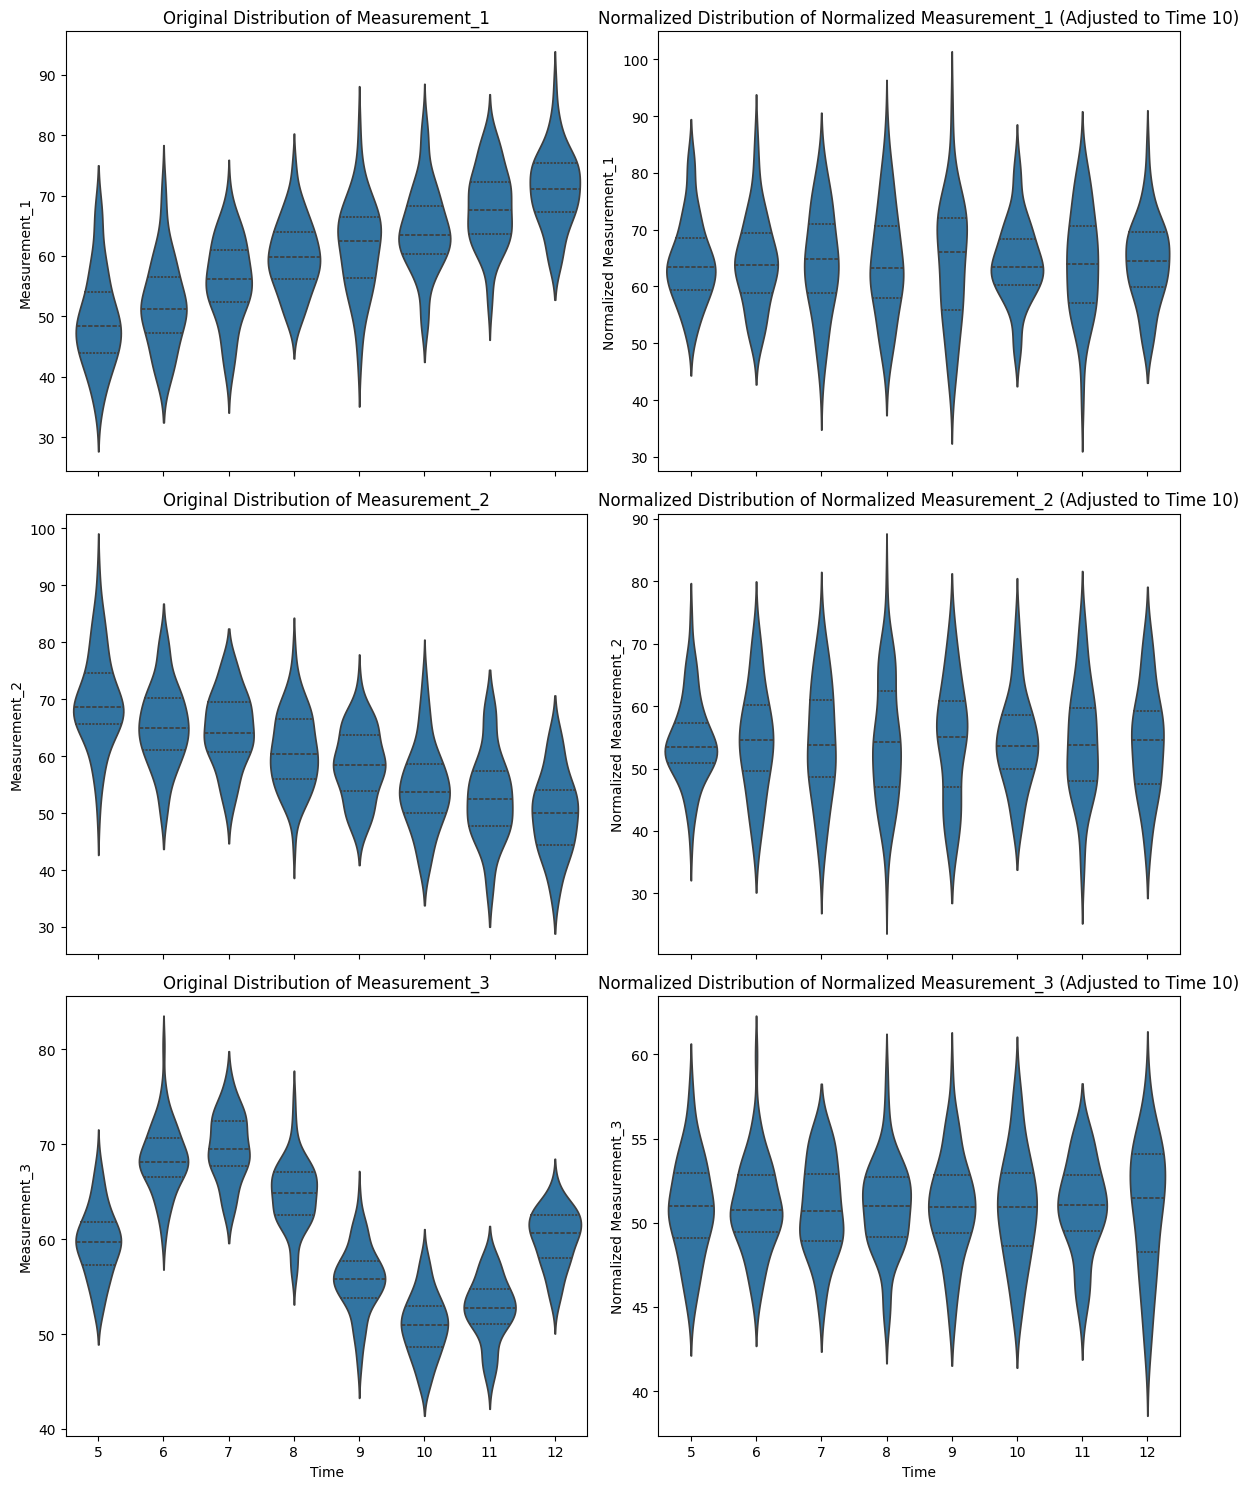

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.linalg import sqrtm, inv, cholesky

# Set random seed for reproducibility
np.random.seed(42)

class DataGenerator:
    def __init__(self, n_samples=500, time_points=None, dim=3, std_dev=None, correlation_matrix=None):
        self.n_samples = n_samples
        self.time_points = time_points if time_points is not None else np.array([5, 6, 7, 8, 9, 10, 11, 12])
        self.dim = dim
        self.std_dev = std_dev if std_dev is not None else np.array([5, 7, 6])
        self.correlation_matrix = correlation_matrix if correlation_matrix is not None else np.array([
            [1.0, 0.7, 0.0],
            [0.7, 1.0, -0.6],
            [0.0, -0.6, 1.0]
        ])
        self.cov_matrix = np.outer(self.std_dev, self.std_dev) * self.correlation_matrix

        # Define different mean trends for each variable
        self.mean_trends = [
            np.linspace(50, 70, len(self.time_points)),  # Variable 1: Increasing
            np.linspace(70, 50, len(self.time_points)),  # Variable 2: Decreasing
            60 + 10 * np.sin(np.linspace(0, 2 * np.pi, len(self.time_points)))  # Variable 3: Random fluctuations
        ]

    def generate_data(self):
        data = []
        for _ in range(self.n_samples):
            t = np.random.choice(self.time_points)  # Each sample has one time point
            t_index = list(self.time_points).index(t)

            # Assign different trends to each variable
            mu_t = np.array([self.mean_trends[i][t_index] for i in range(self.dim)])

            # Generate correlated random variables
            L = cholesky(self.cov_matrix)
            g_i = mu_t + L @ np.random.randn(self.dim)

            data.append([t] + list(g_i))

        columns = ["Time"] + [f"Measurement_{i+1}" for i in range(self.dim)]
        return pd.DataFrame(data, columns=columns)


class Normalizer:
    def __init__(self, df, time_points, ref_time=10, n_components=2):
        self.df = df
        self.time_points = time_points
        self.ref_time = ref_time
        self.n_components = n_components
        self.fitted_means = {}
        self.fitted_covs = {}

    def fit_gmm_models(self):
        for t in self.time_points:
            subset = self.df[self.df["Time"] == t].iloc[:, 1:].values
            gmm = GaussianMixture(n_components=self.n_components, random_state=42)
            gmm.fit(subset)

            # Compute weighted mean and covariance
            weights = gmm.weights_
            means = gmm.means_
            covariances = gmm.covariances_

            weighted_mean = np.sum(weights[:, None] * means, axis=0)
            weighted_cov = np.sum(weights[:, None, None] * covariances, axis=0)

            self.fitted_means[t] = weighted_mean
            self.fitted_covs[t] = weighted_cov

    def normalize_data(self):
        t_ref = self.ref_time
        mu_ref = self.fitted_means[t_ref]
        cov_ref = self.fitted_covs[t_ref]

        def normalize_multivariate(row):
            t_i = row["Time"]
            mu_t = self.fitted_means[t_i]
            cov_t = self.fitted_covs[t_i]

            whitening_transform = sqrtm(inv(cov_t))
            re_scaling_transform = sqrtm(cov_ref)

            g_original = np.array(row.iloc[1:])
            g_transformed = re_scaling_transform @ whitening_transform @ (g_original - mu_t) + mu_ref

            return pd.Series(g_transformed)

        normalized_columns = [f"Normalized Measurement_{i+1}" for i in range(len(mu_ref))]
        self.df[normalized_columns] = self.df.apply(normalize_multivariate, axis=1)
        return self.df


def plot_violin(df, normalized=False):
    dim = len([col for col in df.columns if "Measurement" in col and "Normalized" not in col])
    fig, axes = plt.subplots(dim, 2, figsize=(12, 5 * dim), sharex=True)

    for i in range(dim):
        measurement_col = f"Measurement_{i+1}"
        normalized_col = f"Normalized Measurement_{i+1}"

        # Original Distribution
        sns.violinplot(x="Time", y=measurement_col, data=df, ax=axes[i, 0], inner="quartile")
        axes[i, 0].set_title(f"Original Distribution of {measurement_col}")
        axes[i, 0].set_ylabel(measurement_col)

        # Normalized Distribution
        sns.violinplot(x="Time", y=normalized_col, data=df, ax=axes[i, 1], inner="quartile")
        axes[i, 1].set_title(f"Normalized Distribution of {normalized_col} (Adjusted to Time {10})")
        axes[i, 1].set_ylabel(normalized_col)

    plt.tight_layout()
    plt.show()


# Main Execution
if __name__ == "__main__":
    # Step 1: Generate Data
    data_gen = DataGenerator()
    df = data_gen.generate_data()

    # Step 2: Normalize Data
    normalizer = Normalizer(df, time_points=data_gen.time_points)
    normalizer.fit_gmm_models()
    df_normalized = normalizer.normalize_data()

    # Step 3: Plot Results
    plot_violin(df_normalized)


In [17]:
normalizer.fitted_means

{np.int64(5): array([49.26476197, 69.89328568, 59.64518772]),
 np.int64(6): array([51.89277475, 65.36206517, 68.4691076 ]),
 np.int64(7): array([55.91563822, 64.72114144, 69.71591343]),
 np.int64(8): array([59.87702341, 61.0590936 , 64.75111232]),
 np.int64(9): array([61.53368926, 58.53936453, 55.73937983]),
 np.int64(10): array([64.34029671, 54.38994522, 50.92056763]),
 np.int64(11): array([68.16158078, 52.73647408, 52.61547547]),
 np.int64(12): array([71.06887507, 50.05610542, 60.11889953])}

# Legacy code below [Ignore]

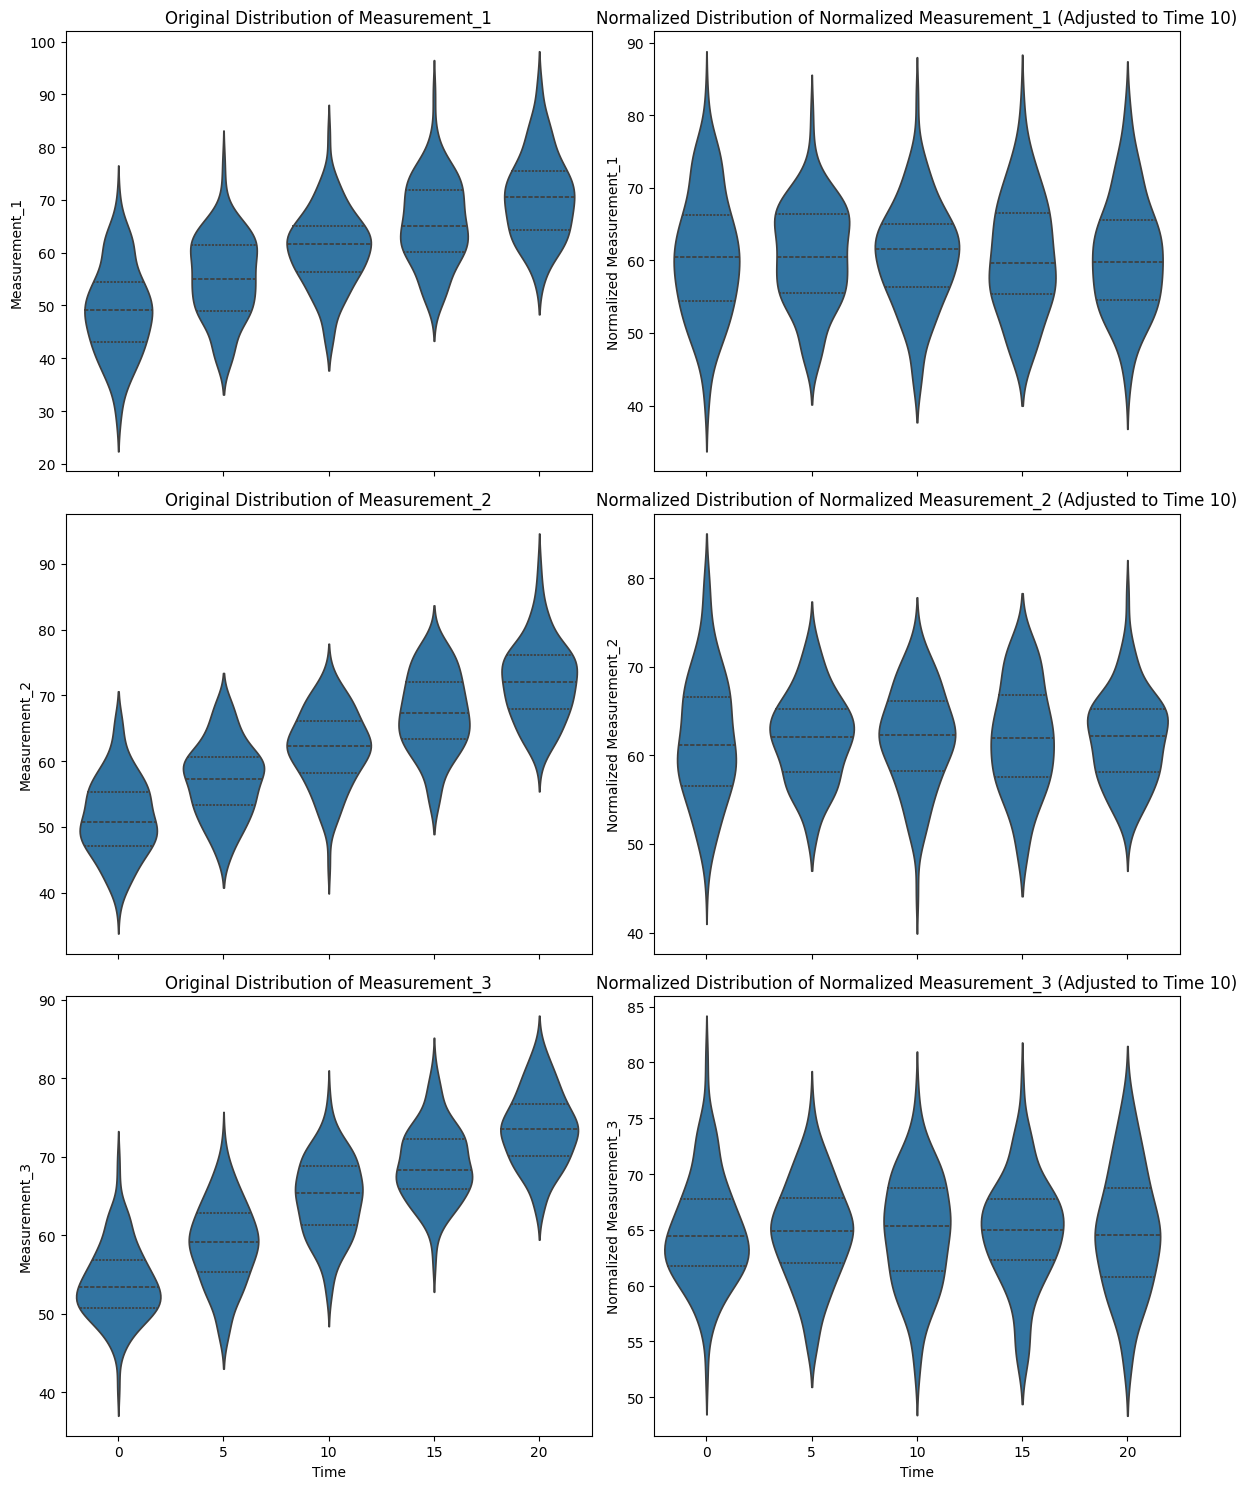

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.linalg import sqrtm, inv, cholesky

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_patients = 500
time_points = np.array([0, 5, 10, 15, 20])  # Discrete time points
dim_g = 3  # Number of dimensions in g_i (adjustable)
std_dev = np.array([5, 7, 6])  # Different standard deviations per variable

# Define a base correlation matrix (should be positive definite)
base_corr = np.array([
    [1.0, 0.7, 0.5],  # Correlation between variables
    [0.7, 1.0, 0.6],
    [0.5, 0.6, 1.0]
])

# Convert to covariance matrix
cov_base = np.outer(std_dev, std_dev) * base_corr  # Σ = D * R * D

# Define time-dependent mean trends
mean_trend = np.linspace(50, 70, len(time_points))  # Mean change over time

# Simulate multivariate measurements (each patient has a single measurement at a given time)
data = []
for i in range(n_patients):
    t = np.random.choice(time_points)  # Each patient has ONE measurement at a single random time
    mu_t = np.array([mean_trend[list(time_points).index(t)] + i * 2 for i in range(dim_g)])

    # Generate correlated random variables using Cholesky decomposition
    L = cholesky(cov_base)  # Cholesky factorization for correlation structure
    g_i = mu_t + L @ np.random.randn(dim_g)  # Apply correlated structure

    data.append([t] + list(g_i))

# Create DataFrame
columns = ["Time"] + [f"Measurement_{i+1}" for i in range(dim_g)]
df = pd.DataFrame(data, columns=columns)

# Fit Multivariate GMMs at each time point
n_components = 2  # Assume 2 subpopulations per time point
fitted_means = {}
fitted_covs = {}

for t in time_points:
    subset = df[df["Time"] == t].iloc[:, 1:].values  # Extract measurement columns
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(subset)

    # Compute the weighted mean and covariance
    weights = gmm.weights_
    means = gmm.means_
    covariances = gmm.covariances_

    weighted_mean = np.sum(weights[:, None] * means, axis=0)
    weighted_cov = np.sum(weights[:, None, None] * covariances, axis=0)

    fitted_means[t] = weighted_mean
    fitted_covs[t] = weighted_cov

# Choose reference time (e.g., time = 10)
t_ref = 10
mu_ref = fitted_means[t_ref]
cov_ref = fitted_covs[t_ref]

# Normalize measurements for all dimensions
def normalize_multivariate(row):
    t_i = row["Time"]
    mu_t = fitted_means[t_i]
    cov_t = fitted_covs[t_i]

    # Whitening transform
    whitening_transform = sqrtm(inv(cov_t))
    re_scaling_transform = sqrtm(cov_ref)

    g_original = np.array(row.iloc[1:])  # Extract measurement vector
    g_transformed = re_scaling_transform @ whitening_transform @ (g_original - mu_t) + mu_ref

    return pd.Series(g_transformed)

# Apply normalization
normalized_columns = [f"Normalized Measurement_{i+1}" for i in range(dim_g)]
df[normalized_columns] = df.apply(normalize_multivariate, axis=1)

# Plot original and normalized distributions for each measurement variable
fig, axes = plt.subplots(dim_g, 2, figsize=(12, 5 * dim_g), sharex=True)

for i in range(dim_g):
    measurement_col = f"Measurement_{i+1}"
    normalized_col = f"Normalized Measurement_{i+1}"

    # Original distribution
    sns.violinplot(x="Time", y=measurement_col, data=df, ax=axes[i, 0], inner="quartile")
    axes[i, 0].set_title(f"Original Distribution of {measurement_col}")
    axes[i, 0].set_ylabel(measurement_col)

    # Normalized distribution
    sns.violinplot(x="Time", y=normalized_col, data=df, ax=axes[i, 1], inner="quartile")
    axes[i, 1].set_title(f"Normalized Distribution of {normalized_col} (Adjusted to Time {t_ref})")
    axes[i, 1].set_ylabel(normalized_col)

plt.tight_layout()
plt.show()


In [3]:
#Using OT - ignore for now
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ot  # POT: Python Optimal Transport

# Generate synthetic data
np.random.seed(42)
n_patients = 500
time_points = np.array([0, 5, 10, 15, 20])
dim_g = 2  # Number of dimensions in g_i

# Simulate multivariate measurements (patients measured only once at random time points)
data = []
for i in range(n_patients):
    t = np.random.choice(time_points)
    mu_t = np.array([50 + (t / 2) + i * 0.5 for i in range(dim_g)])  # Time-dependent mean
    cov_t = np.eye(dim_g) * 5  # Independent feature variance
    g_i = np.random.multivariate_normal(mu_t, cov_t)
    data.append([t] + list(g_i))

df = pd.DataFrame(data, columns=["Time"] + [f"Measurement_{i+1}" for i in range(dim_g)])

# Select a reference time (e.g., t=10)
t_ref = 10
source_data = df[df["Time"] == t_ref].iloc[:, 1:].values  # Target distribution

# Ensure proper mapping of transported data
transformed_data = df.copy()

for t in time_points:
    if t == t_ref:
        continue  # Skip reference time since we normalize everything to it

    # Extract data for the current time
    target_data = df[df["Time"] == t].iloc[:, 1:].values

    if len(target_data) == 0:
        continue  # Skip if no data for this time

    # Compute cost matrix (Euclidean distance)
    cost_matrix = ot.dist(target_data, source_data, metric="euclidean")

    # Define uniform weights for both distributions
    n_source, n_target = len(source_data), len(target_data)
    a, b = np.ones(n_target) / n_target, np.ones(n_source) / n_source  # Equal weights

    # Compute Optimal Transport plan
    transport_plan = ot.emd(a, b, cost_matrix)  # Solve OT problem

    # Compute transported samples via Barycentric Projection
    mapped_data = transport_plan @ source_data  # Move target data towards reference

    # Directly replace transformed data without additional standardization
    transformed_data.loc[df["Time"] == t, df.columns[1:]] = mapped_data

# Plot original and normalized distributions
fig, axes = plt.subplots(dim_g, 2, figsize=(12, 5 * dim_g), sharex=True)

for i in range(dim_g):
    measurement_col = f"Measurement_{i+1}"

    sns.violinplot(x="Time", y=measurement_col, data=df, ax=axes[i, 0], inner="quartile")
    axes[i, 0].set_title(f"Original Distribution of {measurement_col}")

    sns.violinplot(x="Time", y=measurement_col, data=transformed_data, ax=axes[i, 1], inner="quartile")
    axes[i, 1].set_title(f"Normalized Distribution of {measurement_col} (Adjusted to Time {t_ref})")

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'ot'